#1. 언어 설정 및 GPU 설정

수정 -> 노트설정 : GPU 가속

# 2. 드라이브에 파일 읽기 / 쓰기

In [0]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# PyDrive reference:
# https://googledrive.github.io/PyDrive/docs/build/html/index.html

# 2. Create & upload a file text file.
# 특정 폴더 안으로 파일 삽입
uploaded = drive.CreateFile({'title': 'Sample upload.txt', "parents": [{"kind": "drive#fileLink","id": '1MhnuswhW5NCMYJKwUDHBSv9ZpDgypnYE'}]})
uploaded.SetContentString('Sample upload file content')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

# 3. Load a file by ID and print its contents.
downloaded = drive.CreateFile({'id': uploaded.get('id')})
print('Downloaded content "{}"'.format(downloaded.GetContentString()))

Uploaded file with ID 1qsfy-U9Yr5PH8dmKMMuHdmRtvbpYJJKa
Downloaded content "Sample upload file content"


# 3. 케라스 모델파일 읽기 / 쓰기


## 일단 학습

In [0]:
from keras.utils import np_utils
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Activation

# mnist import
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

# 0~1 사이의 값으로 정규화
X_train = X_train.reshape(60000, 784).astype('float32') / 255.0
X_test = X_test.reshape(10000, 784).astype('float32') / 255.0

# 원핫 인코딩
Y_train = np_utils.to_categorical(Y_train)
Y_test = np_utils.to_categorical(Y_test)

model = Sequential()
model.add(Dense(units=64, input_dim=28*28, activation='relu'))
model.add(Dense(units=10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
hist = model.fit(X_train, Y_train, epochs=2, batch_size=32)

loss_and_metrics = model.evaluate(X_test, Y_test, batch_size=32)

print('loss_and_metrics : ' + str(loss_and_metrics))

Using TensorFlow backend.


Epoch 1/2
60000/60000 [==============================] - 4s 65us/step - loss: 0.6570 - acc: 0.8324
Epoch 2/2
10000/10000 [==============================] - 0s 37us/step
loss_and_metrics : [0.2929747213661671, 0.9193]


## 간단한 시각화

Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.38.0-16ubuntu2).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.


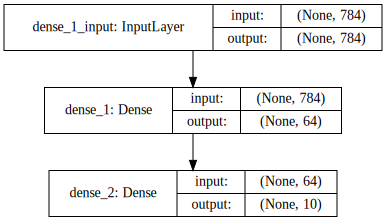

In [0]:
# 학습된 모델 시각화

!pip install pydot
!apt-get install graphviz

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

%matplotlib inline

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [0]:
# VM local root 경로에 모델파일 저장

model.save('mnist_mlp_model.h5')

## 저장이 됐는지 확인

In [0]:
!ls -al

total 460
drwxr-xr-x 1 root root   4096 Jun  7 15:32 .
drwxr-xr-x 1 root root   4096 Jun  7 11:54 ..
drwx------ 4 root root   4096 Jun  7 11:55 .cache
drwxr-xr-x 3 root root   4096 Jun  7 11:55 .config
drwxr-xr-x 1 root root   4096 Jun  7 14:55 datalab
drwxr-xr-x 4 root root   4096 Jun  7 11:55 .forever
drwxr-xr-x 5 root root   4096 Jun  7 11:55 .ipython
drwxr-xr-x 3 root root   4096 Jun  7 15:19 .keras
drwx------ 3 root root   4096 Jun  7 11:55 .local
-rw-r--r-- 1 root root 428056 Jun  7 15:32 mnist_mlp_model.h5
-rw------- 1 root root   1024 Jun  7 11:55 .rnd


## root 경로에 저장된 모델파일을 드라이브의 원하는 폴더에 저장



In [0]:
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# PyDrive reference:
# https://googledrive.github.io/PyDrive/docs/build/html/index.html

# 2. Create & upload a file text file.
# 특정 폴더 안으로 파일 삽입
uploaded = drive.CreateFile({'title': 'mnist_mlp_model.h5', "parents": [{"kind": "drive#fileLink","id": '1MhnuswhW5NCMYJKwUDHBSv9ZpDgypnYE'}]})
uploaded.SetContentFile('mnist_mlp_model.h5')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

# 3. Load a file by ID and print its contents.
downloaded = drive.CreateFile({'id': uploaded.get('id')})

Uploaded file with ID 11RMJNeeZLgUtuuvmyq3LkLBTnTc4vhHh


## REST API로 드라이브에 있는 모델파일을 BytesIO로 다운로드
- 다운로드한 buffer를 tmp 폴더에 파일로 저장

In [0]:
from google.colab import auth
auth.authenticate_user()

from googleapiclient.discovery import build
drive_service = build('drive', 'v3')

import io
from io import BytesIO   
from googleapiclient.http import MediaIoBaseDownload

request = drive_service.files().get_media(fileId='11RMJNeeZLgUtuuvmyq3LkLBTnTc4vhHh')
downloaded = io.BytesIO()
downloader = MediaIoBaseDownload(downloaded, request)
done = False
while done is False:
  status, done = downloader.next_chunk()
  if status:
      print("Download %%%d%%." % int(status.progress() * 100))
  print("Download Complete!")

downloaded.seek(0)

with open('/tmp/mnist_mlp_model.h5', 'wb') as f:
    f.write(downloaded.read())

Download %100%.
Download Complete!


## 원하는 경로에 제대로 다운로드 되었는지 확인

In [0]:
from keras.models import load_model

loaded_model = load_model('/tmp/mnist_mlp_model.h5')

## 다운로드한 모델파일을 import하여 predict로 테스트

In [0]:
import numpy as np
from numpy import argmax

xhat_idx = np.random.choice(X_test.shape[0], 5)
xhat = X_test[xhat_idx]
yhat = loaded_model.predict_classes(xhat)

for i in range(5):
    print('True : ' + str(argmax(Y_test[xhat_idx[i]])) + ', Predict : ' + str(yhat[i]))

True : 6, Predict : 6
True : 7, Predict : 7
True : 9, Predict : 8
True : 1, Predict : 1
True : 5, Predict : 5
